In [1]:
import pandas as pd
import numpy as np
import spacy
import re
import string
import seaborn as sns
from matplotlib import pyplot as plt
from warnings import filterwarnings
from symspellpy import SymSpell, Verbosity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import nltk

In [2]:
filterwarnings(action='ignore')

In [3]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [4]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
# num of missing values

print('num of NaNs in the keywords: ', train_df.keyword.isna().sum())
print('num of NaNs in the locations: ', train_df.location.isna().sum())
print('num of NaNs in the text: ', train_df.text.isna().sum())

num of NaNs in the keywords:  61
num of NaNs in the locations:  2533
num of NaNs in the text:  0


[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'train set')]

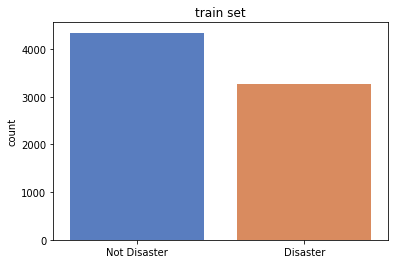

In [6]:
# target distribution

results = train_df.groupby('target', as_index=False)['id'].count()
g = sns.barplot(['Not Disaster', 'Disaster'], results['id'], palette='muted')
g.set(ylabel='count', title='train set')

## length distribution

In [9]:
# train set
length = train_df['text'].apply(lambda x: len(x.replace(' ', '')))

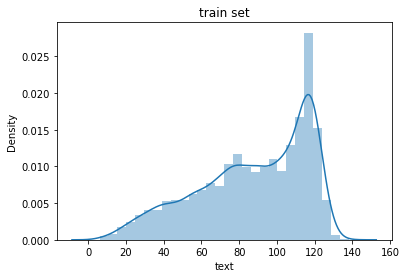

In [10]:
plt.title('train set')
sns.distplot(length)
plt.show()

In [11]:
# test set
length = test_df['text'].apply(lambda x: len(x.replace(' ', '')))

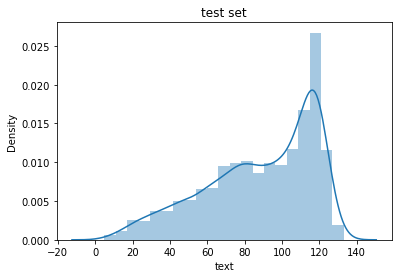

In [12]:
plt.title('test set')
sns.distplot(length)
plt.show()

## Removing stop words

In [13]:
def stopword_remover(text):
    sw_nltk = set(stopwords.words('english'))
    sw_clean = [word for word in text if word not in sw_nltk]
    return sw_clean

## Remove URL and HTML tags and numbers

In [14]:
def url_remover(text):
    # urls
    text = re.sub(
        r'https?://\S+|www\.\S+', '', text)
    
    # html tags
    text = re.sub(r'<.*?>', '', text)
    
    # numbers
    text = re.sub(r'\d+', '', text)

    return text

## Remove punctuation marks

In [15]:
def punctuation_remover(text):
    import string 
    
    punc_clean = [words for words in text if words not in string.punctuation]
    return ''.join(punc_clean)

## Remove Emojies

In [16]:
def emoji_remover(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

## Tokenization

In [17]:
def tokenizer(text):
    tokens = word_tokenize(text)
    return tokens

## Lemmatization

In [18]:
def lemmatizer(text):
    lem = [WordNetLemmatizer().lemmatize(word) for word in text]
    return lem

In [19]:
# hint
# train_df['tokens'] = train_df['tokens'].apply(lambda x: lemmatizer(x))

## converting array to text

In [20]:
def token_to_text(token):
    return ' '.join(token)

In [21]:
# train_df['text'] = train_df['tokens'].apply(lambda x: array_to_text(x))

## Pipeline

In [22]:
def pipline(data):
    data['clean_text'] = data['text'].apply(lambda x: str.lower(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: url_remover(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: emoji_remover(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: punctuation_remover(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: tokenizer(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: stopword_remover(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: lemmatizer(x))
    data['clean_text'] = data['clean_text'].apply(lambda x: token_to_text(x)) 

In [23]:
pipline(train_df)
pipline(test_df)

## Word cloud

### Disaster

In [24]:
def wordcloud_plot(df, target):
    words = []
    for x in df[df['target'] == target]['text'].str.split():
        for i in x:
            words.append(i)
            
    # plotting
    plt.figure(figsize=(12,8))
    word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(words[:50]))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

Disaster


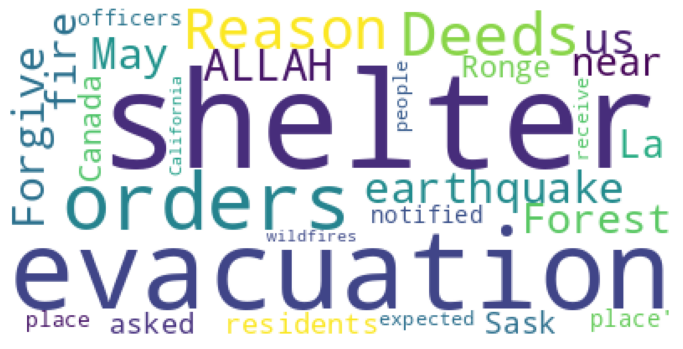

In [25]:
print('Disaster')
wordcloud_plot(train_df, 1)

### Not disaster

Not A Disaster


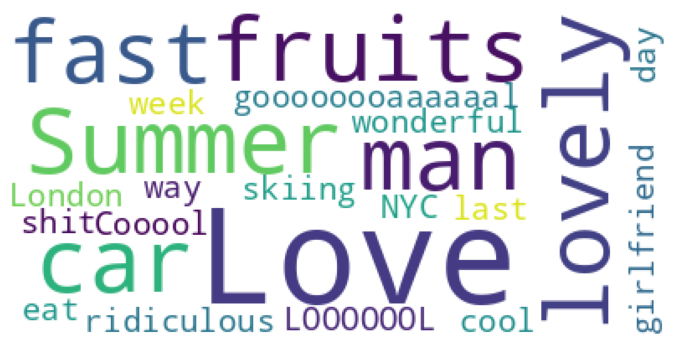

In [26]:
print('Not A Disaster')
wordcloud_plot(train_df, 0)

## Train and test split

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

In [28]:
X_train, X_val, y_train, y_val = train_test_split(train_df['clean_text'].to_numpy(
), train_df['target'].to_numpy(), test_size=0.2, random_state=42)

## Bag of words

In [29]:
tf_transformer = TfidfVectorizer().fit(X_train)
train_features = tf_transformer.transform(X_train)

val_features = tf_transformer.transform(X_val)

In [33]:
nv = MultinomialNB()
rf = RandomForestClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lgbm', lgbm), ('rf', rf), ('nv', nv), ('xgb', xgb)], voting='hard')

for clf in (nv, rf, lgbm, xgb, voting_clf):
    clf.fit(train_features, y_train)
    print(clf.__class__.__name__, accuracy_score(y_val, clf.predict(val_features)))

MultinomialNB 0.8010505581089954
RandomForestClassifier 0.783322390019698
LGBMClassifier 0.778069599474721
[22:36:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.7754432042022325
[22:36:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier 0.793827971109652


In [34]:
test = test_df['text']

In [37]:
test_features = tf_transformer.transform(test)

In [47]:
y_pred = nv.predict(test_features)

In [48]:
submission = pd.DataFrame(columns=['id', 'target'])

In [49]:
submission['id'] = test_df['id']
submission['target'] = y_pred


In [50]:
submission.to_csv('sub.csv', index=False)

In [51]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1
